# Zillow Regression Project 
# Insert Snappy Title Here

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from pydataset import data

import wrangle as w
import explore as ex
import evaluate as ev


from scipy import stats
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# set and use zillow color palette
zpalette = ['#1277e1', '#f3ad35', '#0b449c', '#5289e4', '#c3eafb']
sns.set_palette(zpalette)
sns.color_palette()

[(0.07058823529411765, 0.4666666666666667, 0.8823529411764706),
 (0.9529411764705882, 0.6784313725490196, 0.20784313725490197),
 (0.043137254901960784, 0.26666666666666666, 0.611764705882353),
 (0.3215686274509804, 0.5372549019607843, 0.8941176470588236),
 (0.7647058823529411, 0.9176470588235294, 0.984313725490196)]

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Acquire / Prepare
#### Goals
- get data 
- look at and deal with nulls and duplicates
- understand what I'm looking at

In [3]:
# get data using sql query and wrangle function

df = w.get_zillow_data()

In [4]:
# take a peak at data
df.head()

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,has_pool,garage_car_count,fips,tax_amount,transaction_date
0,11721753,205123.0,2.0,3.0,1316.0,NaN,NaN,6037.0,2627.48,2017-07-21
1,11289917,136104.0,2.0,3.0,1458.0,1.0,NaN,6037.0,2319.90,2017-06-23
2,11705026,35606.0,1.0,2.0,1421.0,NaN,NaN,6037.0,543.69,2017-06-30
3,14269464,880456.0,3.0,4.0,2541.0,NaN,2.0,6059.0,9819.72,2017-06-01
4,11446756,107110.0,2.0,3.0,1491.0,NaN,NaN,6037.0,1399.27,2017-08-23


In [5]:
# look at column info see if there's anything need to change as far as types
# can see some nulls
# need to change date to a datetime object 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28124 entries, 0 to 28123
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   parcel_id         28124 non-null  int64  
 1   tax_value         28123 non-null  float64
 2   bathroom_cnt      28124 non-null  float64
 3   bedroom_cnt       28124 non-null  float64
 4   sqft_calculated   28077 non-null  float64
 5   has_pool          6130 non-null   float64
 6   garage_car_count  9953 non-null   float64
 7   fips              28124 non-null  float64
 8   tax_amount        28123 non-null  float64
 9   transaction_date  28124 non-null  object 
dtypes: float64(8), int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
# change transaction_date to datetime object
# line is in wrangle.py
df['transaction_date'] = pd.to_datetime(df.transaction_date)

In [7]:
df.duplicated().value_counts()

False    28124
dtype: int64

In [8]:
w.missing_values_table(df)

Your selected dataframe has 10 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
has_pool,21994,78.2
garage_car_count,18171,64.6
sqft_calculated,47,0.2
tax_value,1,0.0
tax_amount,1,0.0


#### Takeaways Nulls / Dupes
- There are no duplicate rows! 
- Missing values in pool and garage car count will be filled with 0
- Garage car count will be changed to new boolian variable has_garage
    - anything over 1 will be changed to 1 any 0s or NaNs will be 0s
- Not too many missing values. Will drop rows with missing values after cleaning pool and garage variables
    - 47 sqft missing - DROP
    - 1 tax_value - DROP
    - 1 tax_amount DROP (thought about keeping it just for modeling and throwing it out for county tax info but it's just 1 row)

In [9]:
# fill nans with 0s
# add to function
df['has_pool'] = df.has_pool.fillna(value=0)

In [10]:
# fill nas with 0s for garage
df.garage_car_count.fillna(value=0, inplace=True)

# add new column has garage as boolian. anything over 1 is having a garage, 0 no garage
# ad to function
df['has_garage'] = (df.garage_car_count != 0).astype(int)

In [11]:
#drop the rows with NaNs
df.drop(df[df.isna().any(axis=1)].index, inplace=True)

In [12]:
# look at unique values in each column
for col in df.drop(columns=['parcel_id', 'tax_value', 'tax_amount']).columns:
    print(f'---------------')
    print(f'There are {df[col].nunique()} unique values in the {col} column')

---------------
There are 20 unique values in the bathroom_cnt column
---------------
There are 13 unique values in the bedroom_cnt column
---------------
There are 4055 unique values in the sqft_calculated column
---------------
There are 2 unique values in the has_pool column
---------------
There are 14 unique values in the garage_car_count column
---------------
There are 3 unique values in the fips column
---------------
There are 119 unique values in the transaction_date column
---------------
There are 2 unique values in the has_garage column


#### 1 bathroom and 0 bedrooms with sqftage might be a studio! I will keep those in

#### 0 Bathroom and 0 (or any number of) bedrooms with sqftage will be dropped. can't guess how many beds and bathrooms those have

In [13]:
total_rows = df.shape[0] 
rows_with =  df[df.bathroom_cnt == 0].shape[0]

print(f'There are {total_rows} total rows, {rows_with} with 0 in the bathroom_cnt column.')
print(f'If we drop these rows there should be {total_rows-rows_with} rows left')
print(f'It\'s {rows_with/total_rows:.2%} of the data')

There are 28075 total rows, 23 with 0 in the bathroom_cnt column.
If we drop these rows there should be 28052 rows left
It's 0.08% of the data


In [14]:
# drop the rows with the 0 bathroom count
df.drop(df[df.bathroom_cnt == 0].index, inplace=True)

# check shape
df.shape

(28052, 11)

### Target
- tax_value

### Variables 
#### Categorial variables:
- fips
- bedrooms
- bathrooms 

EXTRA features
- has_pool
- has_garage

#### Continous variables:
- sqft_calculated
- transaction_date 

#### Other
- parcel_id - unique identifer
- tax_amount - not used for modeling

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Explore 
#### Goals 
- Univariate exploration 
    - find and deal with outliers
- train, validate, test split
- Multivariate exploration
- Vizualize relationship between variables and target
- Find Drivers
- State Hypotheses and run some Statistical Tests


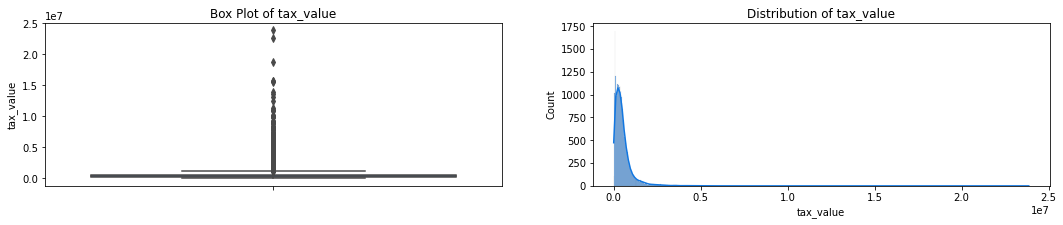

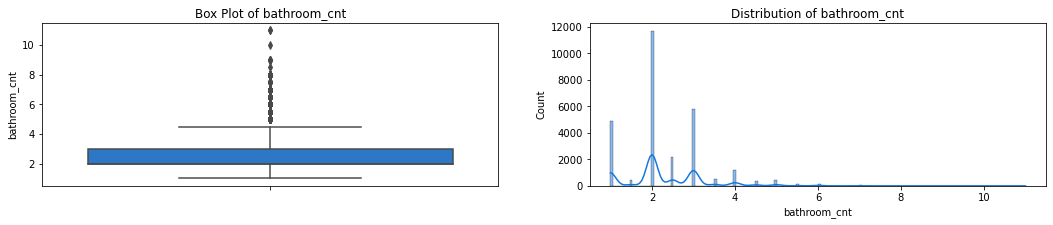

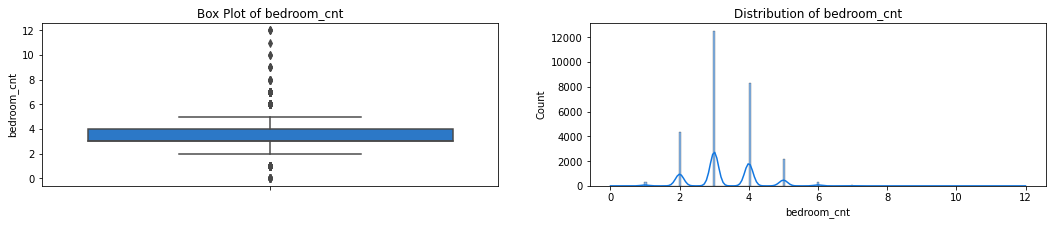

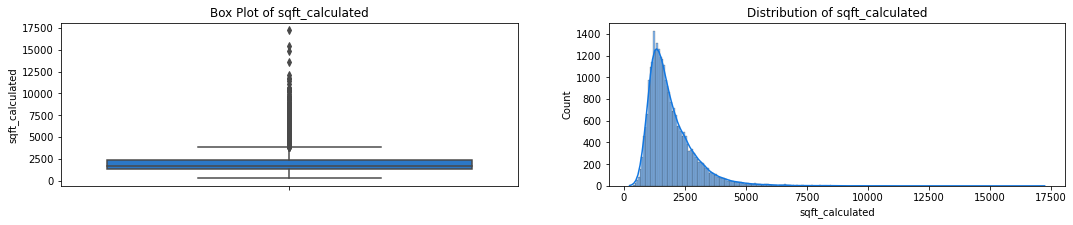

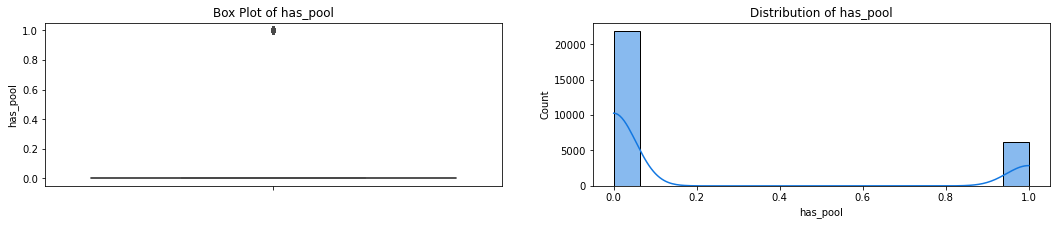

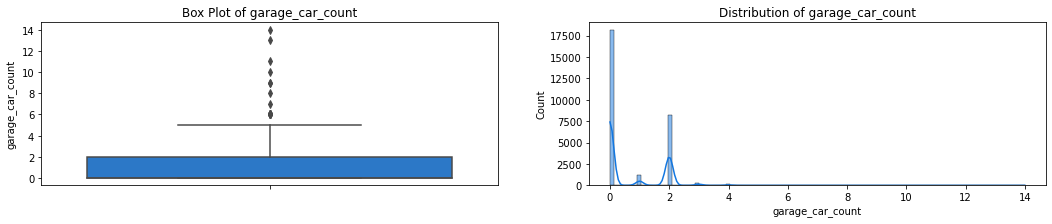

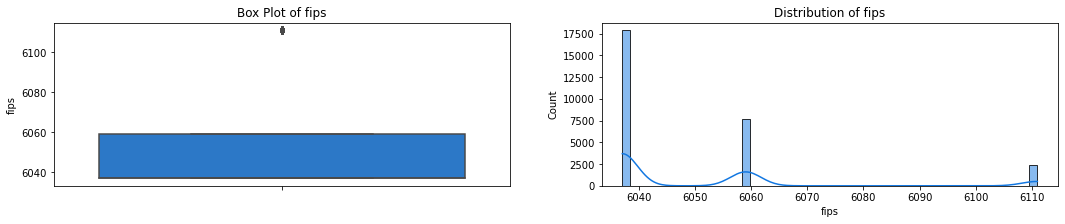

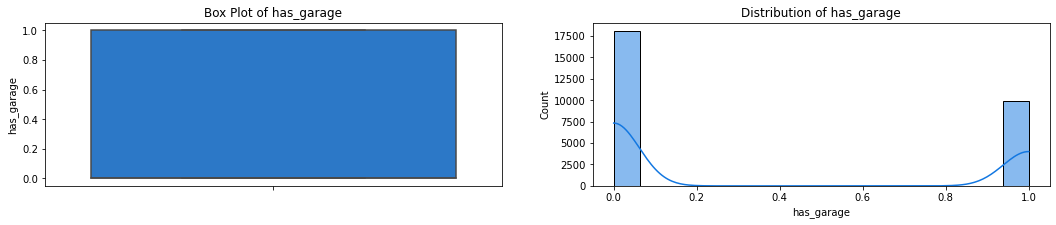

In [15]:
# use function from explore to look at distributions
ex.explore_univariate(df.drop(columns=['parcel_id', 'transaction_date', 'tax_amount']))

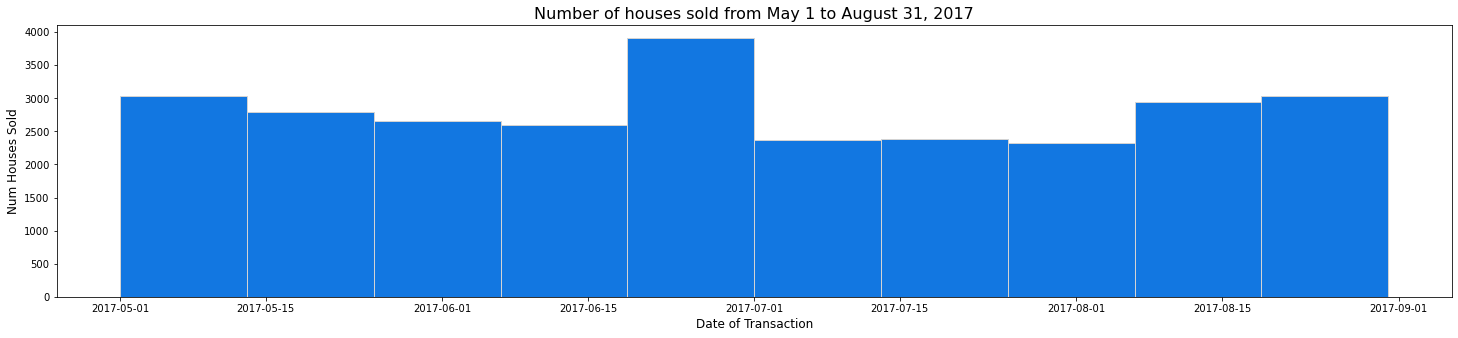

In [16]:
# plot dates houses were sold
plt.figure(figsize=(25, 5))
plt.hist(df.transaction_date, lw = 1, ec = 'lightgrey')
plt.xlabel('Date of Transaction', fontsize = 12)
plt.ylabel('Num Houses Sold', fontsize = 12)
plt.title('Number of houses sold from May 1 to August 31, 2017', fontsize = 16)
plt.show()

### Takeaways
- Need to drop outliers
    - drop outliers in bedroom_cnt, bathroom_cnt, and sqft_calculated with absolute value z_score above 3
    - done in wrangle file
- most of the houses are in LA county (fips 6037)
- The second half of June 2017 saw higher number of house sales

### Train, Validate, Test Split and Bivarate Exploration

In [17]:
# get data with wrangle function, all things above dealt with
df = w.wrangle_zillow()

In [18]:
train, validate, test = w.banana_split(df)

train --> (15349, 10)
validate --> (6579, 10)
test --> (5483, 10)


In [19]:
train.columns

Index(['parcel_id', 'tax_value', 'bathroom_cnt', 'bedroom_cnt',
       'sqft_calculated', 'has_pool', 'fips', 'tax_amount', 'transaction_date',
       'has_garage'],
      dtype='object')

In [20]:
# drop columns I don't need for exploration
train = train.drop(columns=['parcel_id', 'fips', 'tax_amount', 'transaction_date'])

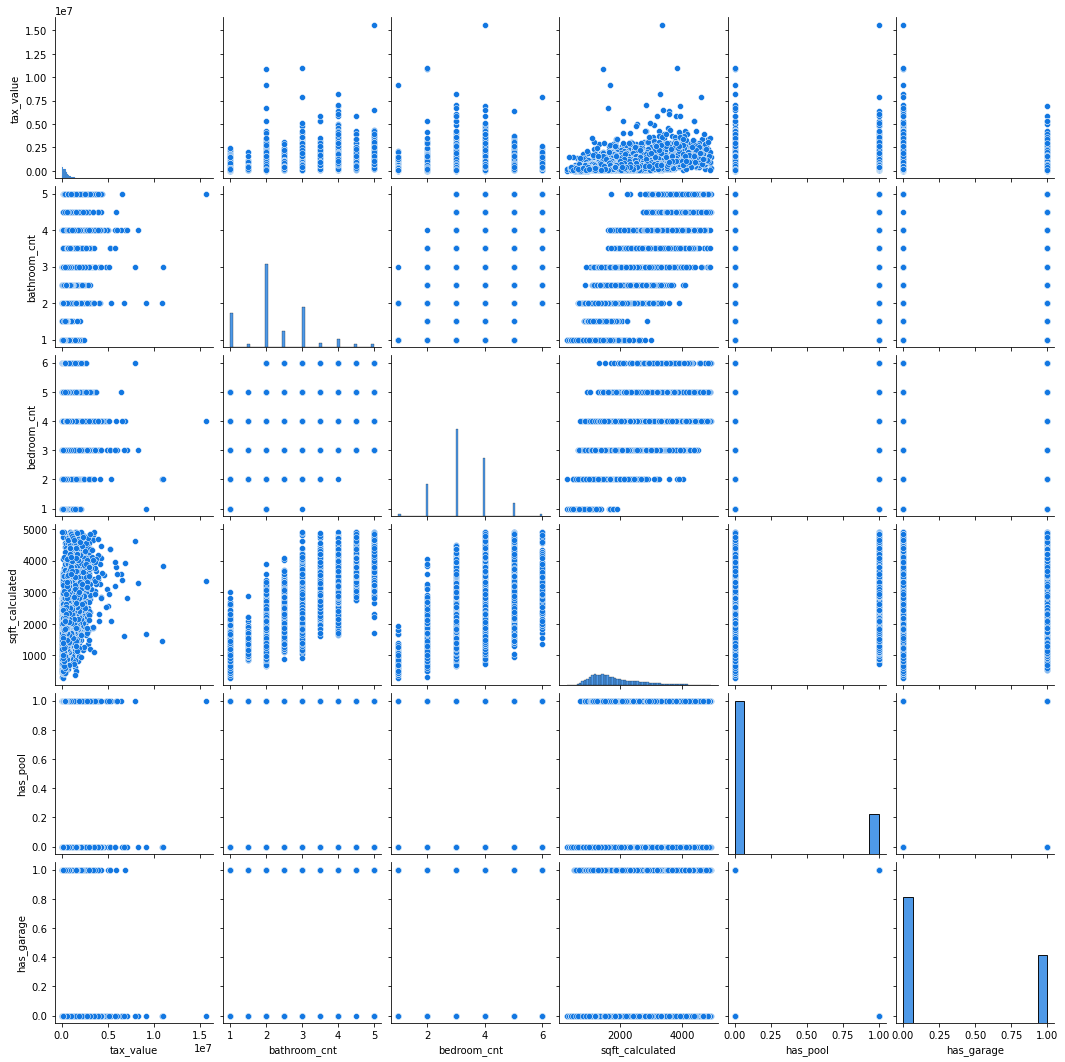

In [21]:
sns.pairplot(train)

#### Takeaways
- As I suspected the bigger the house the bigger the cost
- more bedrooms a place have the more bathrooms it has as well

In [22]:
# use minmax scaler on sqft_calculated 
scaler, scaled_cols = w.my_scaler(train, validate, test, ['sqft_calculated'], MinMaxScaler(), 'mm')

Your scaled columns have been added to your train validate and test dataframes.


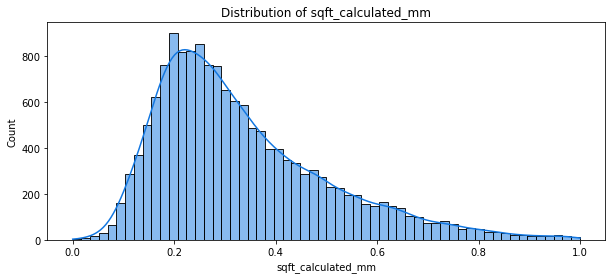

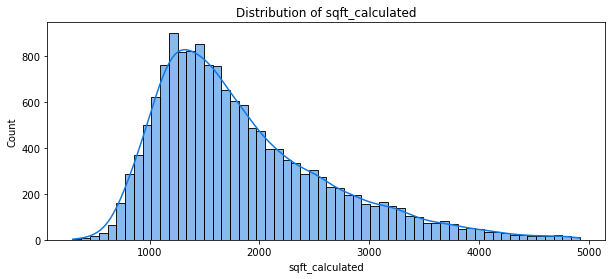

In [23]:
# vizualize sclaed data vs original data
ex.plot_variable_dist(train[['sqft_calculated_mm', 'sqft_calculated']], figsize = (10,4))

<AxesSubplot:>

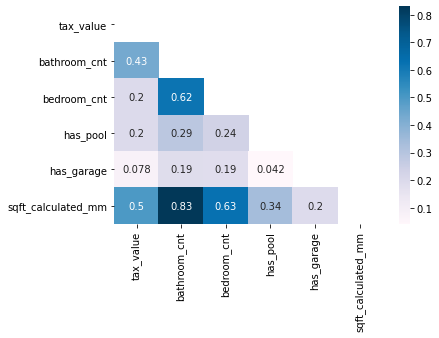

In [24]:
correlation = train.drop(columns='sqft_calculated').corr()
sns.heatmap(correlation, cmap='PuBu', annot = True, mask = np.triu(correlation))

#### Takeaways
- Seems like sqftage and Bathroom count have the highest corelation with tax_value
- but nothing super strong

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Hypothesis Testing

Alpha = 0.05
Confidence interval = 0.95

${H_0}$ There is no linear coorrelation between total square footage and tax value (home value)
${H_a}$ There is a significant linear correlation between total square footage and tax value (home value)

Test: Pearson R

${H_0}$ There is no linear correlation between number of bathrooms and tax value (home value) 
${H_a}$ There is a linear correlation between number of bathrooms and tax value (home value)

(in this case I am considering number of bathroom a continous variable)

Test: Pearson R

In [25]:
# number of samples
n = test.shape[0]
# degrees of freedom
deg_f = n-2
# confidence interval
conf_in = 0.95
alpha = 0.05

n, deg_f, conf_in, alpha

(5483, 5481, 0.95, 0.05)

In [26]:
corr, p = stats.pearsonr(train.sqft_calculated_mm, train.tax_value)

if p < alpha:
    print(f'''Correlation is :{corr:.4}
p value is {p}
We can reject our null hypothesis that sqft caclulated and tax value have no linear correlation.
There is evidence to support the alternate hypothesis.''')
if p > alpha:
    print(f'We cannot reject the null hypothesis')

Correlation is :0.4987
p value is 0.0
We can reject our null hypothesis that sqft caclulated and tax value have no linear correlation.
There is evidence to support the alternate hypothesis.


In [27]:
corr, p = stats.pearsonr(train.bathroom_cnt, train.tax_value)

if p < alpha:
    print(f'''Correlation is :{corr:.4}
p value is {p}
We can reject our null hypothesis that number of bathrooms and tax value have no linear correlation.
There is evidence to support the alternate hypothesis.''')
if p > alpha:
    print(f'We cannot reject the null hypothesis')

Correlation is :0.4341
p value is 0.0
We can reject our null hypothesis that number of bathrooms and tax value have no linear correlation.
There is evidence to support the alternate hypothesis.


<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Modeling
#### Goals
- Establish and create a basline
    - Evaluate the basline
- Create at least 2 models (GLM) and try to beat the baseline metrics

#### Why GLM?
- The target resembles a gamma distribution
- Will try with power = 2: Gamma Distribution
- Then try with power 1

#### Variables
- First tries are with bathroom_cnt (not scaled), bedroom_cnt (not scaled) and sqft_calculated_mm (scaled)
    - variable set 1
- Second tries are with bathroom_cnt_mm (scaled), bedroom_cnt_mm (scaled) sqft_calcualted_mm (scaled), and has_pool (not scaled)
    - variable set 2

### Baseline
- mean and median, see which one is better

In [64]:
# establish X and y
y_train = train.tax_value
X_train = train[['bathroom_cnt', 'bedroom_cnt', 'sqft_calculated_mm']]

y_validate = validate.tax_value
X_validate = validate[['bathroom_cnt', 'bedroom_cnt', 'sqft_calculated_mm']]

y_test = test.tax_value
X_test = test[['bathroom_cnt', 'bedroom_cnt', 'sqft_calculated_mm']]

In [61]:
# add predictions to dataframes
train['baseline_mean'] = train.tax_value.mean()
train['baseline_median'] = train.tax_value.median()

validate['baseline_mean'] = train.tax_value.mean()
validate['baseline_median'] = train.tax_value.median()

In [65]:
# set up baseline and look at rmse
ev.compare_rmse([(train.baseline_mean, y_train), (validate.baseline_mean, y_validate), (train.baseline_median, y_train), (validate.baseline_median, y_validate) ])

RMSE for baseline_mean: 517847.1556156348 
RMSE for baseline_mean: 507373.1158085087 
RMSE for baseline_median: 529876.0897366606 
RMSE for baseline_median: 519735.8115959378 


#### Takeaways
- baseline mean is slightly better than median, will use mean
- rmse to beat, 518,747.16

In [31]:
ev.select_kbest(X_train, y_train, 2)

['bathroom_cnt', 'sqft_calculated_mm']

### GLM 1
- power 2
- variable set 1

In [32]:
glm = TweedieRegressor(power=2, alpha=0)

#fit model
glm.fit(X_train, y_train)

#put predictions in train dataframe
train['glm1'] = glm.predict(X_train)

#put predictions in validate dataframe
validate['glm1'] = glm.predict(X_validate)

ev.compare_rmse([(train.glm1, y_train), (validate.glm1, y_validate)])

RMSE for glm1: 437801.4940931357 
RMSE for glm1: 423090.1024367479 


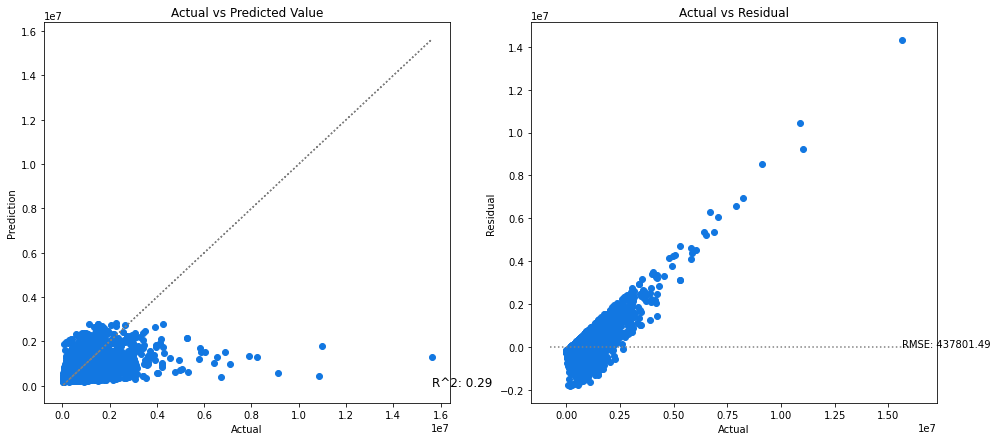

In [33]:
ev.plot_the_dots(y_train, train.glm1, y_train - train.glm1)

### GLM 2

In [34]:
glm = TweedieRegressor(power=1, alpha=0)

#fit model
glm.fit(X_train, y_train)

#put predictions in train dataframe
train['glm2'] = glm.predict(X_train)

#put predictions in validate dataframe
validate['glm2'] = glm.predict(X_validate)

ev.compare_rmse([(train.glm2, y_train), (validate.glm2, y_validate)])

RMSE for glm2: 436360.85483579006 
RMSE for glm2: 421843.1479689872 


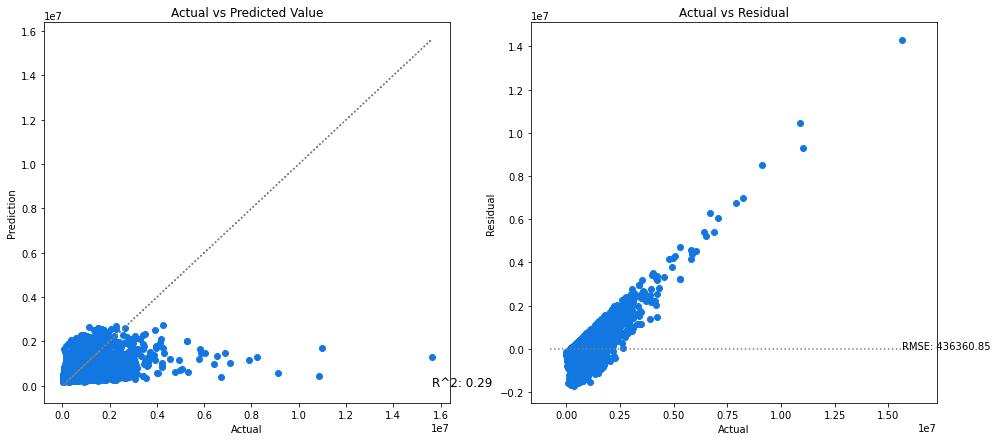

In [35]:
ev.plot_the_dots(y_train, train.glm2, y_train - train.glm2)

### Lasso Lars 1
- alpha 1
- variable set 1

In [36]:
lars = LassoLars(alpha=1.0)

#fit model
lars.fit(X_train, y_train)

#put predictions in train dataframe
train['lars1'] = lars.predict(X_train)

#put predictions in validate dataframe
validate['lars1'] = lars.predict(X_validate)

ev.compare_rmse([(train.lars1, y_train), (validate.lars1, y_validate)])

RMSE for lars1: 440453.360144387 
RMSE for lars1: 427991.05147970235 


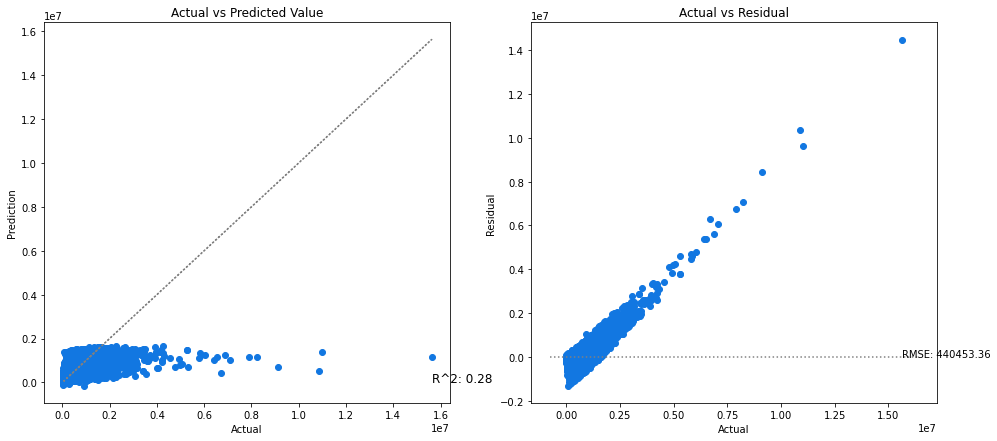

In [37]:
ev.plot_the_dots(y_train, train.lars1, y_train - train.lars1)

In [38]:
col_names = ['bathroom_cnt', 'bedroom_cnt', 'sqft_calculated']

MM_scaler, scaled_cols = w.my_scaler(train, validate, test, col_names, MinMaxScaler(), 'mm')

Your scaled columns have been added to your train validate and test dataframes.


In [39]:
# establish X and y
y_train = train.tax_value
X_train = train[['bathroom_cnt_mm', 'bedroom_cnt_mm', 'sqft_calculated_mm', 'has_pool']]

y_validate = validate.tax_value
X_validate = validate[['bathroom_cnt_mm', 'bedroom_cnt_mm', 'sqft_calculated_mm', 'has_pool']]

y_test = test.tax_value
X_test = test[['bathroom_cnt_mm', 'bedroom_cnt_mm', 'sqft_calculated_mm', 'has_pool']]

In [40]:
ev.select_kbest(X_train, y_train, 3)

['bathroom_cnt_mm', 'sqft_calculated_mm', 'has_pool']

In [41]:
ev.rfe(X_train, y_train, 4)

['bathroom_cnt_mm', 'bedroom_cnt_mm', 'sqft_calculated_mm', 'has_pool']

### GLM3

In [42]:
glm = TweedieRegressor(power=2, alpha=0)

#fit model
glm.fit(X_train, y_train)

#put predictions in train  dataframe
train['glm3'] = glm.predict(X_train)

#put predictions in validate dataframe
validate['glm3'] = glm.predict(X_validate)

ev.compare_rmse([(train.glm3, y_train), (validate.glm3, y_validate)])

RMSE for glm3: 437416.92686737183 
RMSE for glm3: 422590.8926269492 


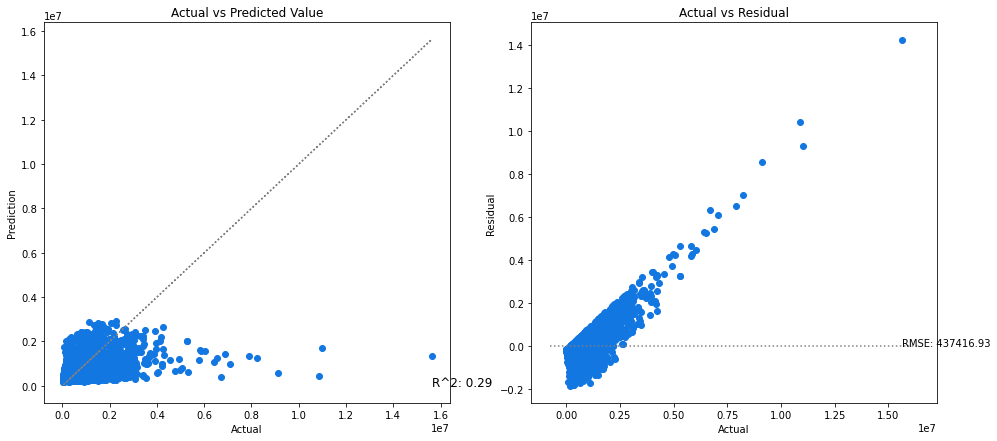

In [43]:
ev.plot_the_dots(y_train, train.glm3, y_train - train.glm3)

In [44]:
glm = TweedieRegressor(power=1, alpha=0)

#fit model
glm.fit(X_train, y_train)

#put predictions in train dataframe
train['glm4'] = glm.predict(X_train)

#put predictions in validate dataframe
validate['glm4'] = glm.predict(X_validate)

ev.compare_rmse([(train.glm4, y_train), (validate.glm4, y_validate)])

RMSE for glm4: 436014.88399324956 
RMSE for glm4: 421398.6618623294 


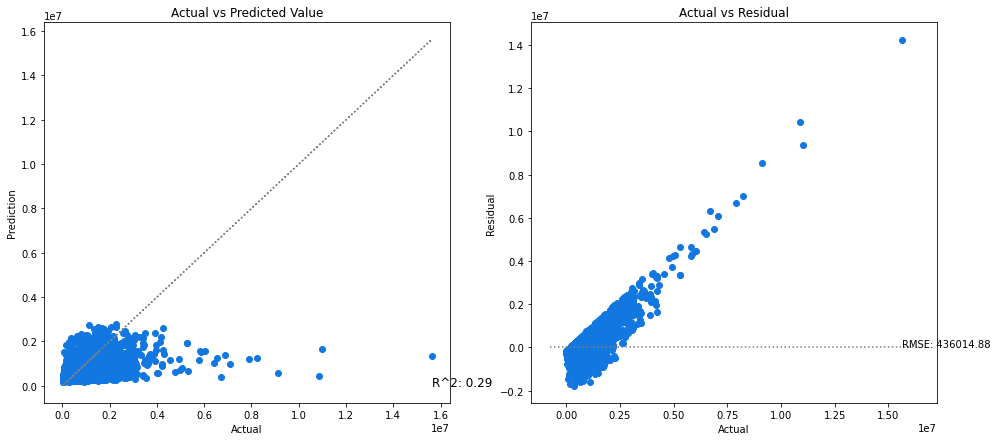

In [45]:
ev.plot_the_dots(y_train, train.glm4, y_train - train.glm4)

In [46]:
model_list = ['glm1', 'glm2', 'glm3', 'glm4', 'lars1']

for model in model_list:
    ev.compare_rmse([(train[model], y_train), (validate[model], y_validate)])

RMSE for glm1: 437801.4940931357 
RMSE for glm1: 423090.1024367479 
RMSE for glm2: 436360.85483579006 
RMSE for glm2: 421843.1479689872 
RMSE for glm3: 437416.92686737183 
RMSE for glm3: 422590.8926269492 
RMSE for glm4: 436014.88399324956 
RMSE for glm4: 421398.6618623294 
RMSE for lars1: 440453.360144387 
RMSE for lars1: 427991.05147970235 


### Takeaways Models
- Model glm4 performed the best
- Train RMSE for glm4: 436014.88
- Validate RMSE for glm4: 421398.66
- Pretty close together not overfit
- From the graph below can see that the top 3 performing models do very close to the same on the validate set
- We're going to go forward with glm4

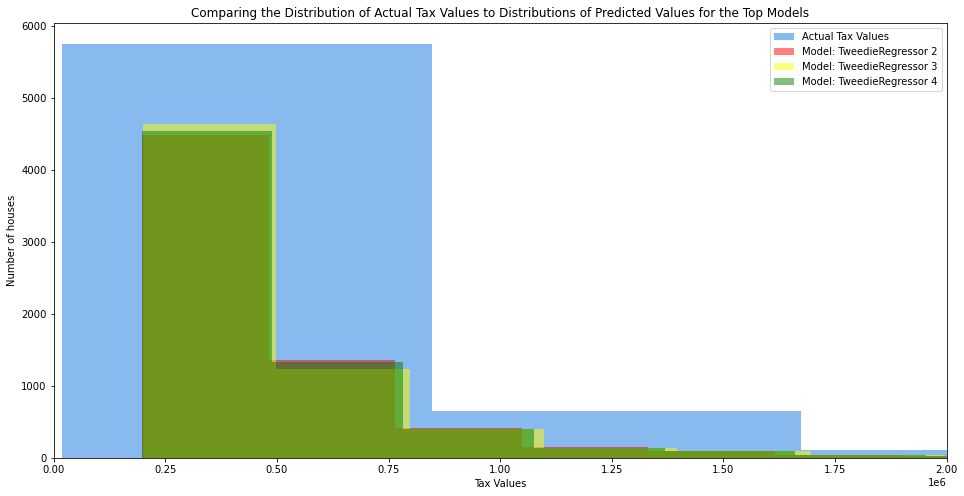

In [55]:
plt.figure(figsize=(16,8))
plt.hist(validate.tax_value, color='#1277e1', alpha=.5, label="Actual Tax Values")
plt.hist(validate.glm2, color='red', alpha=.5, label="Model: TweedieRegressor 2")
plt.hist(validate.glm3, color='yellow', alpha=.5, label="Model: TweedieRegressor 3")
plt.hist(validate.glm4,color='green', alpha=.5, label="Model: TweedieRegressor 4")
plt.xlim((0,2000000))
plt.xlabel("Tax Values")
plt.ylabel("Number of houses")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Values for the Top Models")
plt.legend()
plt.show()

### GLM 4 Test

In [56]:
glm = TweedieRegressor(power=1, alpha=0)

#fit model
glm.fit(X_train, y_train)

#put predictions in test dataframe
test['glm4'] = glm.predict(X_test)

ev.compare_rmse([(test.glm4, y_test)])

RMSE for glm4: 398827.4065351634 


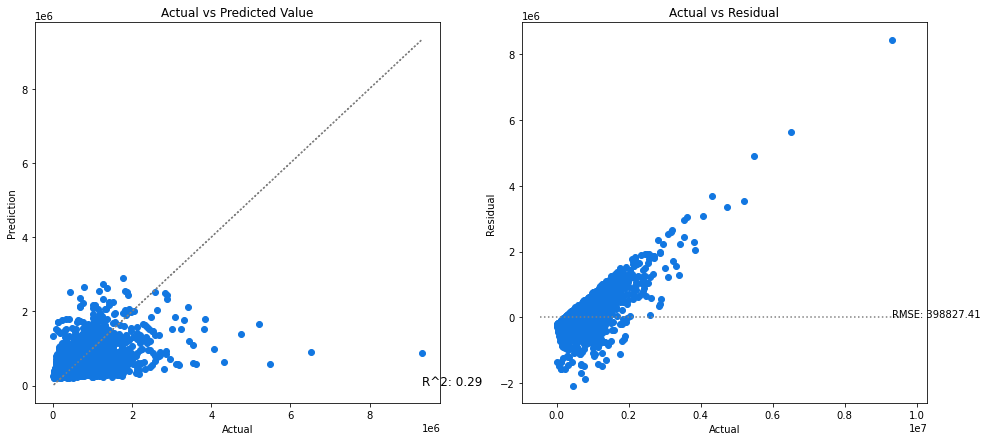

In [52]:
ev.plot_the_dots(y_test, test.glm4, y_test-test.glm4)

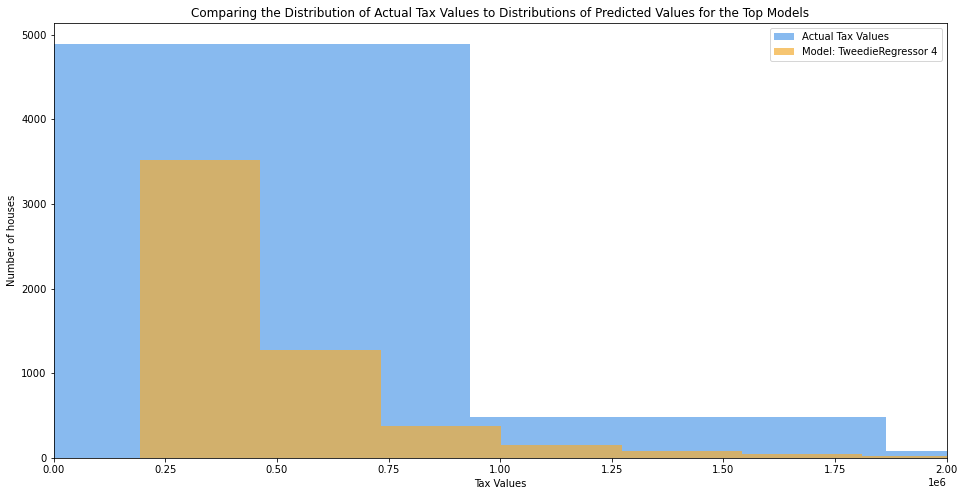

In [60]:
plt.figure(figsize=(16,8))
plt.hist(test.tax_value, color='#1277e1', alpha=.5, label="Actual Tax Values")
plt.hist(test.glm4,color='#f3ad35', alpha=.7, label="Model: TweedieRegressor 4")
plt.xlim((0,2000000))
plt.xlabel("Tax Values")
plt.ylabel("Number of houses")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Values for the Top Models")
plt.legend()
plt.show()

### Takeaways 
- model GLM4 did quite well on the test set
- RMSE 398,827.40
- I believe a contricuting factor to the RMSE is lower because there aren't as many datapoints

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Conclusion 

- using the variables, number of bedrooms, number of bathrooms, square footage, and has a pool, I was able to create a 